# (Q1) The Missing Country

There was a bug in the code and for one specific country, the records don't have the country field logged. It just shows up as an empty field (""). The search sessions with a missing country either come from a country that is completely missing from the data, or from one of the countries that are logged in the data. Can you determine which country it is the most likely to be? Explain your hypothesis and the data analysis tasks you did to find the missing country.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from tqdm import tnrange, tqdm_notebook
import itertools
import datetime
from prettytable import PrettyTable

import os
import sys
sys.path.append('../Tools')
from DataBuilder import read_data

## Solution

A preliminary inspection of the data shows that for each search session, we have the following information available:

1. searched cities
2. UNIX timestamp for that session
3. unique ID of the user
4. joining date of the user
5. the country of the user

The goal is to analyze the usefulness of the first 4 features in order to find the patterns that are useful in detecting the missing country.

In [2]:
# first create a flattened dataframe, using the "read_data" function

data = read_data('../Data/city_search.json')

# now we have a dataframe where each row corresponds to a search session
# and each column to a feature type

countries = sorted(list(data.country.unique()))
countries.append(countries.pop(countries.index('UNK')))

cities = sorted(list(set(itertools.chain.from_iterable(data['cities'].tolist()))))

### Step 1: Inspecting the Searched Cities

For each country, we plot the count of each searched city, in order to see if:

1. users from different countries have a specific preference in searching cities, and
2. if the users from the missing country follow a similar pattern to another country

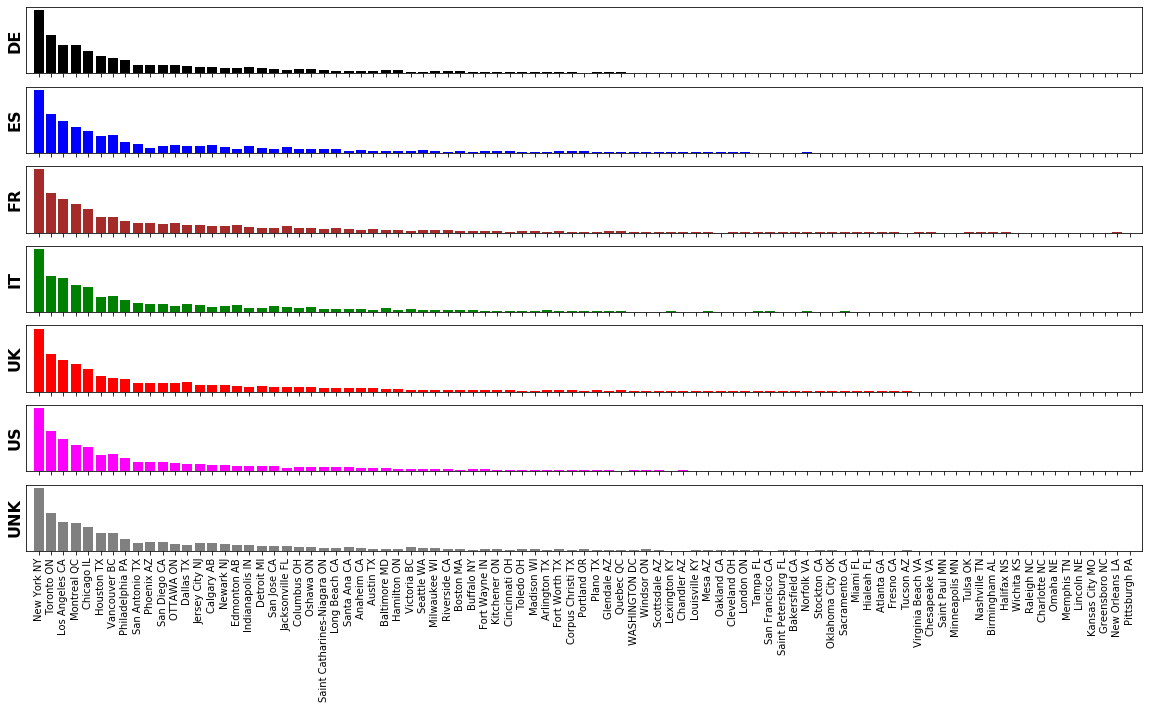

In [3]:
# Cities Searched

colors = ['black', 'blue', 'brown', 'green', 'red', 'magenta', 'grey']

count_cities = np.zeros((len(countries), len(cities)), dtype=int)
for i, country in enumerate(countries):
    cities_searched = list(itertools.chain.from_iterable(data[data['country'] == country]['cities'].tolist()))
    for j, city in enumerate(cities):
        count_cities[i, j] = cities_searched.count(city)
idx = np.argsort(np.mean(count_cities, axis=0))[::-1]
count_cities = np.array([count_cities[:, i] for i in idx]).T
sorted_cities = [cities[i] for i in idx]
        
plt.figure(figsize=(20,10))
for i, country in enumerate(countries):
    plt.subplot(len(countries), 1, i+1)
    plt.bar(sorted_cities, count_cities[i, :], color=colors[i])
    plt.ylabel(country, fontweight='bold', fontsize=16)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    if country == 'UNK':
        plt.tick_params(axis='x', which='both', rotation=90)
    else:
        plt.tick_params(axis='x', which='both', labelbottom=False)
    plt.xlim(-1, len(cities))
plt.show()

Looking at the figures above, we see that all countries follow a similar pattern in terms of searched cities, and the missing country's users follow this pattern, too. As a result, the searched cities do not prove as a discriminative feature between different countries.


### Step 2: Inspection of the Access Times

Using the UNIX timestamp, we first extract the time within the day for each search session. Then we calculate the mean and standard deviation of the access time for the users of each country, as well as the missing country, and plot the normal distribution of them, to compare the distribution for the missing country with other countries.

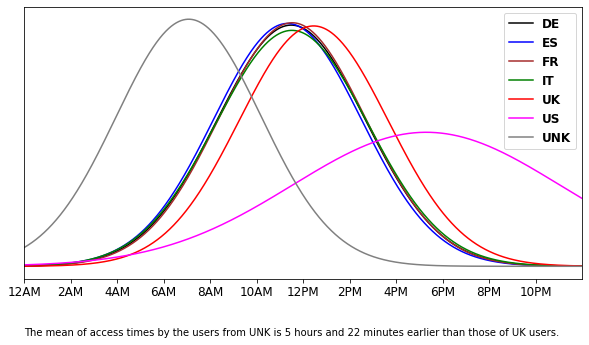

In [4]:
# Inspection of the Access Times

x = np.arange(0, 86400.1, 0.1)
plt.figure(figsize=(10,5))
for i, country in enumerate(countries):
    times = np.array(data[data['country'] == country]['unix_timestamp']) % 86400
    plt.plot(x, stats.norm.pdf(x, np.mean(times), np.std(times)), label=country, color=colors[i])
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.tick_params(axis='x', which='both', labelsize=12)
plt.xlim(0, 86400)
plt.xticks(np.arange(0, 86400, 7200), ['12AM']+['%dAM' % t for t in range(2, 12, 2)]+['12PM']+['%dPM' % t for t in range(2, 12, 2)])
plt.legend(loc=0, prop={'weight':'bold', 'size':12})

uk_mean = np.mean(np.array(data[data['country'] == 'UK']['unix_timestamp']) % 86400)
unk_mean = np.mean(np.array(data[data['country'] == 'UNK']['unix_timestamp']) % 86400)
plt.text(50, -1e-5, 'The mean of access times by the users from UNK is %d hours and %d minutes earlier than those of UK users.' \
    % ((uk_mean-unk_mean)//3600, ((uk_mean-unk_mean)%3600)//60))

plt.show()

The figure above shows that:

1. the distribution for the European countries is very similar and concentrated over a particular time-span, while the mean of the distribution for US is far on the right, showing that the distributions are pretty much dependent upon the time-zome of the countries;
2. the distribution for US is less concentrated than the European countries, as expected based on the width of US, which covers a wider range of time-zones.

For the missing country, it can be observed that the mean access time is 5 hours and 22 minutes ahead of UK. Based on this, we can guess that the missing country's time-zone is 5-6 hours ahead of UK's time. Also, based on the concentration of the distribution for the missing country, it can be hypothesized that the missing country should not be as wide as US, and it probably covers a single time-zone.


### Step 3) Estimation of Population

First, we check the number of users from each country, and we compare that with the population of the country (the population of the countries was collected from https://www.worldometers.info/world-population/population-by-country/). Having the number of users and the population for each given country, we would like to see if there is a correlation between the two, which can potentially help us in having an estimate of the population of the missing country. 

In [5]:
# Estimation of Population

population = ['82.8M', '46.7M', '67.0M', '60.5M', '66.4M', '327.2M', '???']
user_count = np.zeros((len(countries)), dtype=int)

for i, country in enumerate(countries):
    user_count[i] = len(data[data['country'] == country]['user_id'].unique())

idx = np.argsort(user_count)[::-1]
sorted_countries = [countries[i] for i in idx]
user_count = [user_count[i] for i in idx]
population = [population[i] for i in idx]

table = PrettyTable()
table.field_names = ['']+sorted_countries
table.add_row(['# of Users']+user_count)
table.add_row(['Population']+population)

print(table)

+------------+--------+-------+-------+-----+-------+-------+-------+
|            |   US   |   DE  |   UK  | UNK |   FR  |   ES  |   IT  |
+------------+--------+-------+-------+-----+-------+-------+-------+
| # of Users |  1129  |  1051 |  1043 | 792 |  665  |  569  |  528  |
| Population | 327.2M | 82.8M | 66.4M | ??? | 67.0M | 46.7M | 60.5M |
+------------+--------+-------+-------+-----+-------+-------+-------+


The table above shows that, in general, the more populated a country is, the higher its number of users is. The table (having the countries sorted by the number of users) also shows that, the number of users for the unknown country is between that of UK and France. Knowing that the searched cities all belong to US and Canada, and the missing country is presumably located farther away from US and Canada compared to France (based on the access time distribution, discussed above), we can assume that the missing country is far more populated that France, to allow for such a number of users.

Checking populated countries which fall in the estimated time-zone (around 5 and a half hours ahead of UK's), makes __India__ a good candidate. But, let's first check the remaining features to see if they also support our assumption.


### Step 4) Inspection of the Days in the Week for Sessions

Below, the proportion of search sessions per week day for each country is plotted. We would like to see if users from different countries have a preferred weekday to do their search.

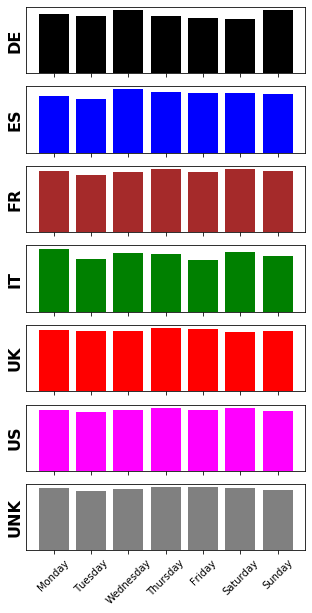

In [6]:
# Inspection of the Days in the Week for Sessions

week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_distribution = np.zeros((len(countries), 7))

for i, country in enumerate(countries):
    data_subset = data.loc[data['country'] == country].reset_index(drop=True)
    for j in range(len(data_subset)):
        day = datetime.datetime.fromtimestamp(data_subset['unix_timestamp'][j]).weekday()
        day_distribution[i, day] += 1
    day_distribution[i, :] /= np.sum(day_distribution[i, :])
    
plt.figure(figsize=(5,10))
for i, country in enumerate(countries):
    plt.subplot(len(countries), 1, i+1)
    plt.bar(week_days, day_distribution[i, :], color=colors[i])
    plt.ylabel(country, fontweight='bold', fontsize=16)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    if country == 'UNK':
        plt.tick_params(axis='x', which='both', rotation=45)
    else:
        plt.tick_params(axis='x', which='both', labelbottom=False)

Looking at the figures above, it can be seen that, there is not a significant difference in the proportion of searches done in different weekdays. As a result, this cannot be used as a discriminative feature.


### Step 5) Inspection of Joining Days

Assuming that joining the platform requires more time (as the user is not yet familiar with the platform, and the registration could take some time), the users might show a more significant preference towards specific weekdays to join the platform than to just access it (inspected in step 4).

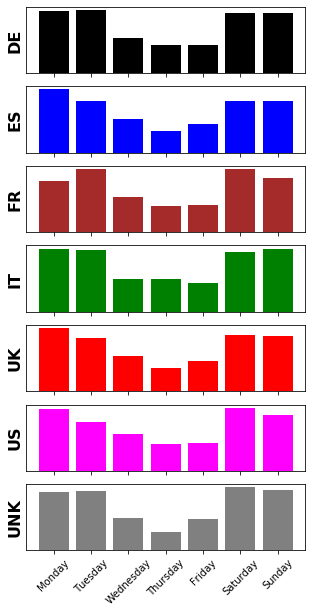

In [7]:
# Inspection of Joining Days

week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_distribution = np.zeros((len(countries), 7))

for i, country in enumerate(countries):
    data_subset = data.loc[data['country'] == country].reset_index(drop=True)
    user_set = set()
    for j in range(len(data_subset)):
        if data_subset['user_id'][j] not in user_set:
            user_set.add(data_subset['user_id'][j])
            l = data_subset['joining_date'][j].split('-')
            day = datetime.date(int(l[0]), int(l[1]), int(l[2])).weekday()
            day_distribution[i, day] += 1
    day_distribution[i, :] /= np.sum(day_distribution[i, :])
    
plt.figure(figsize=(5,10))
for i, country in enumerate(countries):
    plt.subplot(len(countries), 1, i+1)
    plt.bar(week_days, day_distribution[i, :], color=colors[i])
    plt.ylabel(country, fontweight='bold', fontsize=16)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    if country == 'UNK':
        plt.tick_params(axis='x', which='both', rotation=45)
    else:
        plt.tick_params(axis='x', which='both', labelbottom=False)

The figures above show that, in fact, when joining the platform, users show a preference towards some days of the week. Looking at the figures for the 6 given countries, we can see that the users generally prefer to join the platform on the weekends (Saturday and Sunday) and the first two working days of the week.

The missing country follows a similar pattern, based on which we can guess that the weekends in the missing country is also Saturday and Sunday. This is in line with our hypothesis that __India__ is the missing country: a populated country which is around 5 and a half hours ahead of the UK, and has Saturdays and Sundays as the weekends.